<a href="https://colab.research.google.com/github/Megeeee/AI-Exercises/blob/main/basic_model_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import torch.optim as optim

In [123]:

transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.RandomRotation(degrees=25,fill = 0),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset =  datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

print("Download Succesfull!")

Download Succesfull!


In [124]:
class basicModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3,padding=1), #32x28x28
        nn.ReLU(),
        nn.MaxPool2d(2,2),#32x14x14

        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),#64x7x7

        nn.Flatten(),
        nn.Linear(7*7*64,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )

  def forward(self,x):
    return self.model(x)

In [125]:
model = basicModel()
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
basicModel                               [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
│    └─Flatten: 2-7                      [1, 3136]                 --
│    └─Linear: 2-8                       [1, 100]                  313,700
│    └─ReLU: 2-9                         [1, 100]                  --
│    └─Linear: 2-10                      [1, 10]                   1,010
Total params: 333,526
Trainable params: 333,526
Non-trainable params: 0


In [126]:
model = basicModel().to("cuda")

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.002)


Training on:} NVIDIA A100-SXM4-80GB
[Epoch: 1, Batch: 200] loss: 2.290
[Epoch: 1, Batch: 400] loss: 2.265
[Epoch: 1, Batch: 600] loss: 2.232
[Epoch: 1, Batch: 800] loss: 2.182
[Epoch: 2, Batch: 200] loss: 1.998
[Epoch: 2, Batch: 400] loss: 1.781
[Epoch: 2, Batch: 600] loss: 1.499
[Epoch: 2, Batch: 800] loss: 1.204
[Epoch: 3, Batch: 200] loss: 0.875
[Epoch: 3, Batch: 400] loss: 0.751
[Epoch: 3, Batch: 600] loss: 0.671
[Epoch: 3, Batch: 800] loss: 0.610
[Epoch: 4, Batch: 200] loss: 0.567
[Epoch: 4, Batch: 400] loss: 0.543
[Epoch: 4, Batch: 600] loss: 0.503
[Epoch: 4, Batch: 800] loss: 0.476
[Epoch: 5, Batch: 200] loss: 0.465
[Epoch: 5, Batch: 400] loss: 0.435
[Epoch: 5, Batch: 600] loss: 0.439
[Epoch: 5, Batch: 800] loss: 0.409
[Epoch: 6, Batch: 200] loss: 0.390
[Epoch: 6, Batch: 400] loss: 0.399
[Epoch: 6, Batch: 600] loss: 0.383
[Epoch: 6, Batch: 800] loss: 0.373
[Epoch: 7, Batch: 200] loss: 0.363
[Epoch: 7, Batch: 400] loss: 0.343
[Epoch: 7, Batch: 600] loss: 0.333
[Epoch: 7, Batch: 8

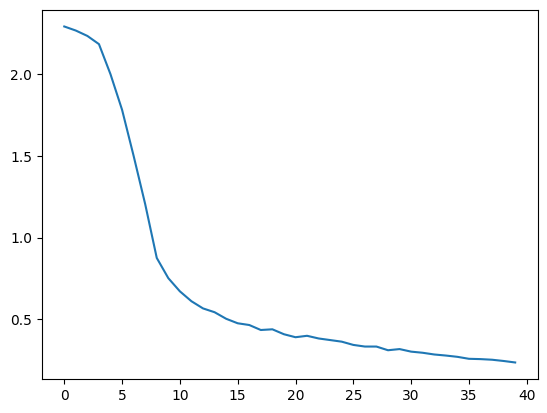

Finished Training


In [127]:
print("Training on:}",torch.cuda.get_device_name(0))

lossL = []
#train
for epoch in range(10):
  running_loss = 0.0
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    input,labels = inputs.to("cuda"),labels.to("cuda")

    optimizer.zero_grad()

    outputs = model(input)
    l = loss(outputs,labels)
    running_loss += l.item()
    l.backward()
    optimizer.step()
    if i % 200 == 199:
            print(f'[Epoch: {epoch + 1}, Batch: {i + 1}] loss: {running_loss / 200:.3f}')
            lossL.append(running_loss/200)
            running_loss = 0.0


plt.plot(lossL)
plt.show()
print('Finished Training')

In [128]:
#test
model.eval()
correct=0
total= 0

with torch.no_grad():
  for data in testloader:
    inputs,labels = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda")
    outputs = model(inputs)

    correct += torch.sum(torch.max(outputs,1)[1]==labels).item()
    total += len(labels)

print("Accuracy:",correct/total)
print("Correct:",correct)
print("total:",total)

Accuracy: 0.9397
Correct: 9397
total: 10000


Actual Labels:     7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5
Model Predictions: 7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5


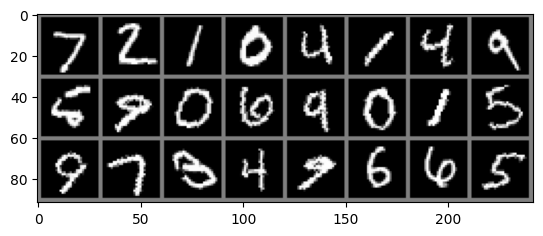

In [130]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize (reverse the (x-0.5)/0.5 operation)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

images_gpu = images.to("cuda")

outputs = model(images_gpu)
a, predicted = torch.max(outputs, 1)

print("Actual Labels:    ", " ".join(f'{labels[j].item()}' for j in range(24)))
print("Model Predictions:", " ".join(f'{predicted[j].item()}' for j in range(24)))

imshow(torchvision.utils.make_grid(images[:24]))